<h1>Data exploration, preprocessing and feature engineering</h1>

In this and the following notebooks we will demonstrate how you can build your ML Pipeline leveraging SKLearn Feature Transformers and SageMaker XGBoost algorithm & after the model is trained, deploy the Pipeline (Feature Transformer and XGBoost) as a SageMaker Inference Pipeline behind a single Endpoint for real-time inference.

In particular, in this notebook we will tackle the first steps related to data exploration and preparation. We will use [Amazon Athena](https://aws.amazon.com/athena/) to query our dataset and have a first insight about data quality and available features, [AWS Glue](https://aws.amazon.com/glue/) to create a Data Catalog and [Amazon SageMaker Processing](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html) for building the feature transformer model with SKLearn.

In [1]:
# When using Amazon SageMaker Studio, please set this variable to True and execute the cell
use_sm_studio = True
if use_sm_studio:
    %cd /root/end-to-end-ml-sm/02_data_exploration_and_feature_eng/

/root/end-to-end-ml-sm/02_data_exploration_and_feature_eng


In [2]:
# Check SageMaker Python SDK version
import sagemaker
print(sagemaker.__version__)

def versiontuple(v):
    return tuple(map(int, (v.split("."))))

if versiontuple(sagemaker.__version__) < versiontuple('2.5.0'):
    raise Exception("This notebook requires at least SageMaker Python SDK version 2.5.0. Please install it via pip.")

2.23.5


In [3]:
import boto3
import time

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker_session.default_bucket()
prefix = 'endtoendmlsm'

print(region)
print(role)
print(bucket_name)

us-east-1
arn:aws:iam::041631420165:role/service-role/AmazonSageMaker-ExecutionRole-endtoendml
sagemaker-us-east-1-041631420165


We can now copy to our bucket the dataset used for this use case. We will use the `windturbine_raw_data_header.csv` made available for this workshop in the `gianpo-public` public S3 bucket. In this Notebook, we will download from that bucket and upload to your bucket so that AWS services can access the data.

In [4]:
import boto3

s3 = boto3.resource('s3')

file_key = 'data/raw/windturbine_raw_data_header.csv'
copy_source = {
    'Bucket': 'gianpo-public',
    'Key': 'endtoendml/{0}'.format(file_key)
}

s3.Bucket(bucket_name).copy(copy_source, '{0}/'.format(prefix) + file_key)

The first thing we need now is to infer a schema for our dataset. Thanks to its [integration with AWS Glue](https://docs.aws.amazon.com/athena/latest/ug/glue-athena.html), we will later use Amazon Athena to run SQL queries against our data stored in S3 without the need to import them into a relational database. To do so, Amazon Athena uses the AWS Glue Data Catalog as a central location to store and retrieve table metadata throughout an AWS account. The Athena execution engine, indeed, requires table metadata that instructs it where to read data, how to read it, and other information necessary to process the data.

To organize our Glue Data Catalog we create a new database named `endtoendml-db`. To do so, we create a Glue client via Boto and invoke the `create_database` method.

However, first we want to make sure these AWS resources to not exist yet to avoid any error.

In [5]:
from notebook_utilities import cleanup_glue_resources
cleanup_glue_resources()

Cleanup completed.


In [6]:
glue_client = boto3.client('glue')

response = glue_client.create_database(DatabaseInput={'Name': 'endtoendml-db'})
response = glue_client.get_database(Name='endtoendml-db')
response
assert response['Database']['Name'] == 'endtoendml-db'

Now we define a Glue Crawler that we point to the S3 path where the dataset resides, and the crawler creates table definitions in the Data Catalog.
To grant the correct set of access permission to the crawler, we use one of the roles created before (`GlueServiceRole-endtoendml`) whose policy grants AWS Glue access to data stored in your S3 buckets.

In [7]:
response = glue_client.create_crawler(
    Name='endtoendml-crawler',
    Role='service-role/GlueServiceRole-endtoendml', 
    DatabaseName='endtoendml-db',
    Targets={'S3Targets': [{'Path': '{0}/{1}/data/raw/'.format(bucket_name, prefix)}]}
)

We are ready to run the crawler with the `start_crawler` API and to monitor its status upon completion through the `get_crawler_metrics` API.

In [8]:
glue_client.start_crawler(Name='endtoendml-crawler')

while glue_client.get_crawler_metrics(CrawlerNameList=['endtoendml-crawler'])['CrawlerMetricsList'][0]['TablesCreated'] == 0:
    print('RUNNING')
    time.sleep(15)
    
assert glue_client.get_crawler_metrics(CrawlerNameList=['endtoendml-crawler'])['CrawlerMetricsList'][0]['TablesCreated'] == 1

RUNNING
RUNNING
RUNNING
RUNNING
RUNNING


When the crawler has finished its job, we can retrieve the Table definition for the newly created table.
As you can see, the crawler has been able to correctly identify 12 fields, infer a type for each column and assign a name.

In [9]:
table = glue_client.get_table(DatabaseName='endtoendml-db', Name='raw')
table

{'Table': {'Name': 'raw',
  'DatabaseName': 'endtoendml-db',
  'Owner': 'owner',
  'CreateTime': datetime.datetime(2021, 2, 3, 7, 5, 36, tzinfo=tzlocal()),
  'UpdateTime': datetime.datetime(2021, 2, 3, 7, 5, 36, tzinfo=tzlocal()),
  'LastAccessTime': datetime.datetime(2021, 2, 3, 7, 5, 36, tzinfo=tzlocal()),
  'Retention': 0,
  'StorageDescriptor': {'Columns': [{'Name': 'turbine_id', 'Type': 'string'},
    {'Name': 'turbine_type', 'Type': 'string'},
    {'Name': 'wind_speed', 'Type': 'bigint'},
    {'Name': 'rpm_blade', 'Type': 'bigint'},
    {'Name': 'oil_temperature', 'Type': 'double'},
    {'Name': 'oil_level', 'Type': 'bigint'},
    {'Name': 'temperature', 'Type': 'bigint'},
    {'Name': 'humidity', 'Type': 'bigint'},
    {'Name': 'vibrations_frequency', 'Type': 'bigint'},
    {'Name': 'pressure', 'Type': 'bigint'},
    {'Name': 'wind_direction', 'Type': 'string'},
    {'Name': 'breakdown', 'Type': 'string'}],
   'Location': 's3://sagemaker-us-east-1-041631420165/endtoendmlsm/data/

Based on our knowledge of the dataset, we can be more specific with column names and types.

In [10]:
# We have to remove the CatalogId key from the dictionary due to an breaking change
# intrduced in botocore 1.17.18.
del table['Table']['CatalogId']

table['Table']['StorageDescriptor']['Columns'] = [{'Name': 'turbine_id', 'Type': 'string'},
                                                  {'Name': 'turbine_type', 'Type': 'string'},
                                                  {'Name': 'wind_speed', 'Type': 'double'},
                                                  {'Name': 'rpm_blade', 'Type': 'double'},
                                                  {'Name': 'oil_temperature', 'Type': 'double'},
                                                  {'Name': 'oil_level', 'Type': 'double'},
                                                  {'Name': 'temperature', 'Type': 'double'},
                                                  {'Name': 'humidity', 'Type': 'double'},
                                                  {'Name': 'vibrations_frequency', 'Type': 'double'},
                                                  {'Name': 'pressure', 'Type': 'double'},
                                                  {'Name': 'wind_direction', 'Type': 'string'},
                                                  {'Name': 'breakdown', 'Type': 'string'}]
updated_table = table['Table']
updated_table.pop('DatabaseName', None)
updated_table.pop('CreateTime', None)
updated_table.pop('UpdateTime', None)
updated_table.pop('CreatedBy', None)
updated_table.pop('IsRegisteredWithLakeFormation', None)

glue_client.update_table(
    DatabaseName='endtoendml-db',
    TableInput=updated_table
)

{'ResponseMetadata': {'RequestId': '52a54cae-43e9-4226-aadf-90b3159b9428',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Wed, 03 Feb 2021 07:08:28 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '52a54cae-43e9-4226-aadf-90b3159b9428'},
  'RetryAttempts': 0}}

<h2>Data exploration with Amazon Athena</h2>

For data exploration, let's install PyAthena, a Python client for Amazon Athena. Note: PyAthena is not maintained by AWS, please visit: https://pypi.org/project/PyAthena/ for additional information.

In [11]:
!pip install s3fs
!pip install pyathena

     |████████████████████████████████| 7.2 MB 23.0 MB/s eta 0:00:01
ERROR: boto3 1.16.56 has requirement botocore<1.20.0,>=1.19.56, but you'll have botocore 1.19.52 which is incompatible.
ERROR: awscli 1.18.216 has requirement botocore==1.19.56, but you'll have botocore 1.19.52 which is incompatible.
  Attempting uninstall: botocore
    Found existing installation: botocore 1.19.56
    Uninstalling botocore-1.19.56:
      Successfully uninstalled botocore-1.19.56


In [12]:
import pyathena
from pyathena import connect
import pandas as pd

athena_cursor = connect(s3_staging_dir='s3://{0}/{1}/staging/'.format(bucket_name, prefix), 
                        region_name=region).cursor()

athena_cursor.execute('SELECT * FROM "endtoendml-db".raw limit 8;')
pd.read_csv(athena_cursor.output_location)

,turbine_id,turbine_type,wind_speed,rpm_blade,oil_temperature,oil_level,temperature,humidity,vibrations_frequency,pressure,wind_direction,breakdown
0,TID003,HAWT,80.0,61.0,NaN,34.0,33.0,26.0,1.0,77.0,E,no
1,TID010,HAWT,85.0,78.0,36.0,28.0,35.0,43.0,15.0,62.0,NE,yes
2,TID007,HAWT,47.0,31.0,31.0,23.0,46.0,62.0,15.0,32.0,N,no
3,TID008,VAWT,73.0,70.0,38.0,8.0,17.0,66.0,6.0,80.0,SW,yes
4,TID003,HAWT,16.0,23.0,46.0,9.0,76.0,53.0,14.0,29.0,W,no
5,TID001,HAWT,78.0,71.0,30.0,11.0,66.0,79.0,1.0,81.0,SW,no
6,TID009,HAWT,80.0,25.0,37.0,31.0,40.0,75.0,4.0,56.0,NW,no
7,TID002,VAWT,59.0,29.0,37.0,10.0,25.0,83.0,13.0,55.0,SE,no


Another SQL query to count how many records we have

In [13]:
athena_cursor.execute('SELECT COUNT(*) FROM "endtoendml-db".raw;')
pd.read_csv(athena_cursor.output_location)

,_col0
0,1000000


Let's try to see what are possible values for the field "breakdown" and how frequently they occur over the entire dataset

In [14]:
athena_cursor.execute('SELECT breakdown, (COUNT(breakdown) * 100.0 / (SELECT COUNT(*) FROM "endtoendml-db".raw)) \
            AS percent FROM "endtoendml-db".raw GROUP BY breakdown;')
pd.read_csv(athena_cursor.output_location)

,breakdown,percent
0,no,86.3421
1,yes,13.6579


<BarContainer object of 2 artists>

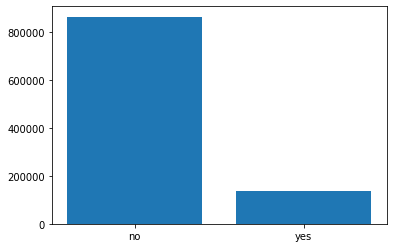

In [15]:
athena_cursor.execute('SELECT breakdown, COUNT(breakdown) AS bd_count FROM "endtoendml-db".raw GROUP BY breakdown;')
df = pd.read_csv(athena_cursor.output_location)

%matplotlib inline
import matplotlib.pyplot as plt

plt.bar(df.breakdown, df.bd_count)

We have discovered that the dataset is quite unbalanced, although we are not going to try balancing it.

In [16]:
athena_cursor.execute('SELECT DISTINCT(turbine_type) FROM "endtoendml-db".raw')
pd.read_csv(athena_cursor.output_location)

,turbine_type
0,HAWT
1,VAWT
2,NaN


In [17]:
athena_cursor.execute('SELECT COUNT(*) FROM "endtoendml-db".raw WHERE oil_temperature IS NULL GROUP BY oil_temperature')
pd.read_csv(athena_cursor.output_location)

,_col0
0,38297


We also realized there are a few null values that need to be managed during the data preparation steps.

For the purpose of keeping the data exploration step short during the workshop, we are not going to execute additional queries. However, feel free to explore the dataset more if you have time.

**Note**: you can go to Amazon Athena console and check for query duration under History tab: usually queries are executed in a few seconds, then it some time for Pandas to load results into a dataframe

## Create an experiment

Before getting started with preprocessing and feature engineering, we want to leverage on Amazon SageMaker Experiments to track the experimentations that we will be executing.
We are going to create a new experiment and then a new trial, that represents a multi-step ML workflow (e.g. preprocessing stage1, preprocessing stage2, training stage, etc.). Each step of a trial maps to a trial component in SageMaker Experiments.

We will use the Amazon SageMaker Experiments SDK to interact with the service from the notebooks. Additional info and documentation is available here: https://github.com/aws/sagemaker-experiments

In [18]:
!pip install sagemaker-experiments

     |████████████████████████████████| 41 kB 29 kB/s s eta 0:00:01
     |████████████████████████████████| 7.2 MB 24.0 MB/s eta 0:00:01
ERROR: awscli 1.18.216 has requirement botocore==1.19.56, but you'll have botocore 1.19.63 which is incompatible.
ERROR: aiobotocore 1.2.0 has requirement botocore<1.19.53,>=1.19.52, but you'll have botocore 1.19.63 which is incompatible.
  Attempting uninstall: botocore
    Found existing installation: botocore 1.19.52
    Uninstalling botocore-1.19.52:
      Successfully uninstalled botocore-1.19.52


Now we are creating the experiment, or loading if it already exists.

In [19]:
import time
from smexperiments import experiment
from botocore.exceptions import ClientError

experiment_name = 'end-to-end-ml-sagemaker-{0}'.format(str(int(time.time())))
print(experiment_name)
current_experiment = None

try:
    current_experiment = experiment.Experiment.load(experiment_name)
    print('Experiment loaded.')
except ClientError as ex:
    if ex.response['Error']['Code'] == 'ResourceNotFound':
        # Create experiment
        current_experiment = experiment.Experiment.create(experiment_name=experiment_name,
                                                          description='SageMaker workshop experiment')
        print('Experiment created.')
    else:
        raise ex

end-to-end-ml-sagemaker-1612336463
Experiment created.


Once we have our experiment, we can create a new trial.

In [20]:
import time

trial_name = 'sklearn-xgboost-{0}'.format(str(int(time.time())))
current_trial = current_experiment.create_trial(trial_name=trial_name)

From now own, we will use the experiment and the trial as configuration parameters for the preprocessing and training jobs, to make sure we track executions.

In [21]:
%store experiment_name
%store trial_name

Stored 'experiment_name' (str)
Stored 'trial_name' (str)


<h2>Preprocessing and Feature Engineering with Amazon SageMaker Processing</h2>

The preprocessing and feature engineering code is implemented in the `source_dir/preprocessor.py` file.

You can go through the code and see that a few categorical columns required one-hot encoding, plus we are filling some NaN values based on domain knowledge.
Once the SKLearn fit() and transform() is done, we are splitting our dataset into 80/20 train & validation and then saving to the output paths whose content will be automatically uploaded to Amazon S3 by SageMaker Processing. Finally, we also save the featurizer model as it will be reused later for inference.

In [22]:
!pygmentize source_dir/preprocessor.py

import argparse
import os
import warnings

import subprocess
subprocess.call(['pip', 'install', 'sagemaker-experiments'])

import pandas as pd
import numpy as np
import tarfile

from smexperiments.tracker import Tracker

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

columns = ['turbine_id', 'turbine_type', 'wind_speed', 'rpm_blade', 'oil_temperature',
           'oil_level', 'temperature', 'humidity', 'vibrations_frequency', 'pressure', 'wind_direction', 'breakdown']

if __name__=='__main__':
    
    # Read the arguments passed to the script.
    parser = argparse.ArgumentParser()
    parser.add_argument('--train-test-split-ratio', type=float, default=0.3)
    args, _ = parser.parse_known_args()
    
   

Configuring an Amazon SageMaker Processing job through the SM Python SDK requires to create a `Processor` object (in this case `SKLearnProcessor` as we are using the default SKLearn container for processing); we can specify how many instances we are going to use and what instance type is requested.

In [23]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor

sklearn_processor = SKLearnProcessor(role=role,
                                     base_job_name='end-to-end-ml-sm-proc',
                                     instance_type='ml.m5.large',
                                     instance_count=1,
                                     framework_version='0.20.0')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


Then, we can invoke the `run()` method of the `Processor` object to kick-off the job, specifying the script to execute, its arguments and the configuration of inputs and outputs as shown below.

In [24]:
raw_data_path = 's3://{0}/{1}/data/raw/'.format(bucket_name, prefix)
train_data_path = 's3://{0}/{1}/data/preprocessed/train/'.format(bucket_name, prefix)
val_data_path = 's3://{0}/{1}/data/preprocessed/val/'.format(bucket_name, prefix)
model_path = 's3://{0}/{1}/output/sklearn/'.format(bucket_name, prefix)

# Experiment tracking configuration
experiment_config={
    "ExperimentName": current_experiment.experiment_name,
    "TrialName": current_trial.trial_name,
    "TrialComponentDisplayName": "sklearn-preprocessing",
}

sklearn_processor.run(code='source_dir/preprocessor.py',
                      inputs=[ProcessingInput(input_name='raw_data', source=raw_data_path, destination='/opt/ml/processing/input')],
                      outputs=[ProcessingOutput(output_name='train_data', source='/opt/ml/processing/train', destination=train_data_path),
                               ProcessingOutput(output_name='val_data', source='/opt/ml/processing/val', destination=val_data_path),
                               ProcessingOutput(output_name='model', source='/opt/ml/processing/model', destination=model_path)],
                      arguments=['--train-test-split-ratio', '0.2'],
                      experiment_config=experiment_config)

INFO:sagemaker:Creating processing-job with name end-to-end-ml-sm-proc-2021-02-03-07-20-29-282



Job Name:  end-to-end-ml-sm-proc-2021-02-03-07-20-29-282
Inputs:  [{'InputName': 'raw_data', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-041631420165/endtoendmlsm/data/raw/', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-041631420165/end-to-end-ml-sm-proc-2021-02-03-07-20-29-282/input/code/preprocessor.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-041631420165/endtoendmlsm/data/preprocessed/train/', 'LocalPath': '/opt/ml/processing/train', 'S3UploadMode': 'EndOfJob'}}, {'OutputName': 'val_data', 'AppManaged': False, 'S3O

Once the job is completed, we can give a look at the preprocessed dataset, by loading the validation features as follows:

In [25]:
file_name = 'val_features.csv'
s3_key_prefix = '{0}/data/preprocessed/val/{1}'.format(prefix, file_name)

sagemaker_session.download_data('./', bucket_name, s3_key_prefix)

In [26]:
import pandas as pd
df = pd.read_csv(file_name)

df.head(10)

,0.0,0.0.1,0.0.2,0.0.3,1.0,0.0.4,0.0.5,0.0.6,0.0.7,0.0.8,...,0.0.15,0.0.16,25.0,30.0,30.0.1,17.0,38.0,16.0,1.0.3,20.0
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,37.0,43.0,41.0,26.0,65.0,71.0,10.0,76.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,22.0,35.0,35.0,22.0,85.0,52.0,3.0,22.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,66.0,41.0,37.0,31.0,37.0,59.0,2.0,30.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,19.0,48.0,49.0,7.0,84.0,38.0,3.0,51.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,65.0,65.0,48.0,17.0,27.0,33.0,2.0,40.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,63.0,26.0,26.0,10.0,50.0,78.0,13.0,59.0
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,79.0,46.0,35.0,11.0,40.0,38.0,2.0,59.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,16.0,48.0,45.0,16.0,17.0,21.0,2.0,49.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,83.0,53.0,38.0,20.0,81.0,46.0,5.0,62.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,38.0,83.0,30.0,35.0,43.0,77.0,4.0,34.0


We can see that the categorical variables have been one-hot encoded, and you are free to check that we do not have NaN values anymore as expected.
Note that exploring the dataset locally with Pandas vs using Amazon Athena is possible given the limited size of the dataset.

### Experiment analytics

You can visualize experiment analytics either from Amazon SageMaker Studio Experiments plug-in or using the SDK from a notebook, as follows:

In [27]:
from sagemaker.analytics import ExperimentAnalytics

analytics = ExperimentAnalytics(experiment_name=experiment_name)
analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,default-oil-temperature,default-turbine-type,train-test-split-ratio,SageMaker.ImageUri - MediaType,...,raw_data - MediaType,raw_data - Value,model - MediaType,model - Value,train_data - MediaType,train_data - Value,val_data - MediaType,val_data - Value,Trials,Experiments
0,end-to-end-ml-sm-proc-2021-02-03-07-20-29-282-...,sklearn-preprocessing,arn:aws:sagemaker:us-east-1:041631420165:proce...,1.0,ml.m5.large,30.0,37.0,HAWT,0.2,None,...,None,s3://sagemaker-us-east-1-041631420165/endtoend...,None,s3://sagemaker-us-east-1-041631420165/endtoend...,None,s3://sagemaker-us-east-1-041631420165/endtoend...,None,s3://sagemaker-us-east-1-041631420165/endtoend...,[sklearn-xgboost-1612336478],[end-to-end-ml-sagemaker-1612336463]


After the preprocessing and feature engineering are completed, you can move to the next notebook in the **03_train_model** folder to start model training.